In [1]:
import os
import csv  
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd



(120, 25, 25)
120


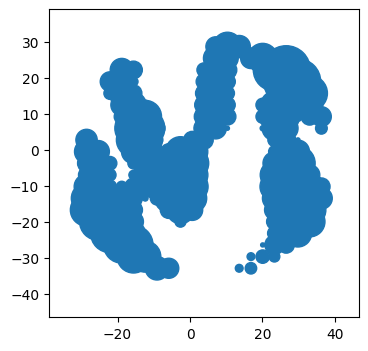

x0
[[-35.05476832 -31.81270432 -28.57064033 -25.32857633 -22.08651233
  -18.84444833 -15.60238433 -12.36032033  -9.11825633  -5.87619233
   -2.63412833   0.60793567   3.84999967   7.09206367  10.33412766
   13.57619166  16.81825566  20.06031966  23.30238366  26.54444766
   29.78651166  33.02857566  36.27063966  39.51270366  42.75476766]
 [-35.05476832 -31.81270432 -28.57064033 -25.32857633 -22.08651233
  -18.84444833 -15.60238433 -12.36032033  -9.11825633  -5.87619233
   -2.63412833   0.60793567   3.84999967   7.09206367  10.33412766
   13.57619166  16.81825566  20.06031966  23.30238366  26.54444766
   29.78651166  33.02857566  36.27063966  39.51270366  42.75476766]
 [-35.05476832 -31.81270432 -28.57064033 -25.32857633 -22.08651233
  -18.84444833 -15.60238433 -12.36032033  -9.11825633  -5.87619233
   -2.63412833   0.60793567   3.84999967   7.09206367  10.33412766
   13.57619166  16.81825566  20.06031966  23.30238366  26.54444766
   29.78651166  33.02857566  36.27063966  39.51270366  42

In [34]:

file_path = os.path.join('D:\\', 'hotaidata')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
x=np.array(x)

y=np.array(y)
vx=np.array(vx)
print(vx.shape)
vx=vx.reshape(120,25,25)
vy=np.array(vy)
isvalid=np.array(isvalid)

vx=vx.T
vy=vy.T
t=np.linspace(0,1,120)
print(len(t))
dt=t[1]-t[0]

vx_dot = ps.FiniteDifference(axis=1)._differentiate(vx, t=dt)
vy_dot = ps.FiniteDifference(axis=1)._differentiate(vy, t=dt)
#x=x.reshape(100,25,25)
#print(vx_dot[:,:,0])
plt.figure(figsize=(4, 4))
plt.scatter(x[0],y[0],s=vx_dot[:,:,0])
plt.show()
#print(vx[50])
print('x0')
print(x[0])
spatial_grid = np.asarray([x[0][0], y[0][0]]).T
#print(spatial_grid)


n=25
u_train=np.zeros((n, n, len(t), 2))
u_train[:, :, :, 0] = vx
u_train[:, :, :, 1] = vy
u_dot_train = ps.FiniteDifference(axis=2)._differentiate(u_train, dt)
#print(u_train)

In [3]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.
library_functions = [
    lambda y: y,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('u_train')
print(u_train.shape)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=50, alpha=1e-5, 
                     normalize_columns=True, max_iter=200)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['Vx','Vy'])
model.fit(u_train, x_dot=u_dot_train)
model.print()
print(u_train.shape)
print(u_train[0].shape)
print(u_train[0][0].shape)
'''
print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(u_train, x_dot=u_dot_train)
model.print()
u_dot_stlsq = model.predict(u_test)
'''


u_train
(25, 25, 120, 2)
STLSQ model: 
(Vx)' = 4.575 1 + 3.305 Vx + 1.079 Vy + -0.029 VxVxVx + -0.006 VyVyVy + -0.011 VxVyVy + -0.014 VxVxVy + -0.619 Vx_1 + -5.501 Vy_1 + 9.561 Vx_11 + -0.871 Vy_11 + -5.405 VxVx_1 + -0.323 VxVy_1 + 0.005 VyVx_1 + -0.001 VyVy_1 + 0.014 VxVxVxVx_1 + -0.003 VxVxVxVy_1 + 0.346 VyVyVyVx_1 + 1.541 VyVyVyVy_1 + 0.011 VxVyVyVx_1 + -0.001 VxVyVyVy_1 + -0.001 VxVxVyVx_1 + -0.008 VxVxVyVy_1 + -5.244 VxVx_11 + 4.178 VxVy_11 + -0.003 VyVx_11 + -0.005 VyVy_11 + 0.026 VxVxVxVx_11 + -0.036 VxVxVxVy_11 + -5.224 VyVyVyVx_11 + -0.534 VyVyVyVy_11 + 0.021 VxVyVyVx_11 + -0.001 VxVyVyVy_11 + 0.001 VxVxVyVx_11 + -0.011 VxVxVyVy_11
(Vy)' = 0.638 1 + -2.488 Vx + 0.754 Vy + -0.005 VxVxVx + -0.003 VyVyVy + -0.001 VxVyVy + -0.049 VxVxVy + -6.976 Vy_1 + -5.748 Vx_11 + -1.022 Vy_11 + 0.048 VxVx_1 + 7.404 VxVy_1 + -0.006 VyVx_1 + -0.011 VyVy_1 + 0.012 VxVxVxVx_1 + -0.010 VxVxVxVy_1 + -10.912 VyVyVyVx_1 + -0.165 VyVyVyVy_1 + 0.003 VxVyVyVx_1 + -0.001 VxVyVyVy_1 + 0.013 VxVxVyVx_1 + -0

"\nprint('SINDy')\nmodel = ps.SINDy(feature_names=['Vx','Vy'])\n\nmodel.fit(u_train, x_dot=u_dot_train)\nmodel.print()\nu_dot_stlsq = model.predict(u_test)\n"

In [43]:
t_test=np.arange(0,25,1)
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(u_train)
print(type(x_dot_test_predicted))
#print(x_dot_test_predicted[0])
#print(x_dot_test_predicted.shape)
pltpredict=np.array(x_dot_test_predicted.reshape(25,25,120,2))

print(type(pltpredict[:,:,0,1]))

<class 'pysindy.utils.axes.AxesArray'>
<class 'numpy.ndarray'>


(25,)
(120, 25, 25)
[ 35.25746989  32.01540589  28.77334189  25.53127789  22.2892139
  19.0471499   15.8050859   12.5630219    9.3209579    6.0788939
   2.8368299   -0.4052341   -3.6472981   -6.8893621  -10.1314261
 -13.3734901  -16.61555409 -19.85761809 -23.09968209 -26.34174609
 -29.58381009 -32.82587409 -36.06793809 -39.31000209 -42.55206609]


<Figure size 400x400 with 0 Axes>

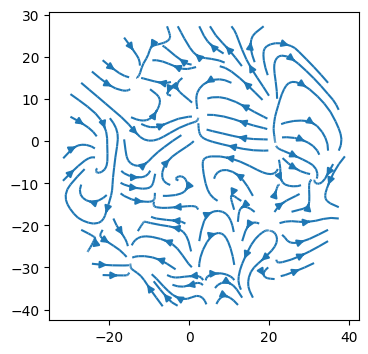

x
(25, 25)
vx_dot[:,:,i]
(25, 25)
pltpredict[:,:,i,0]
(25, 25)


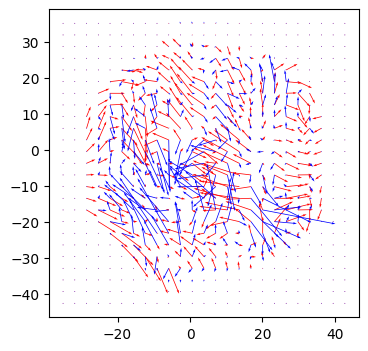

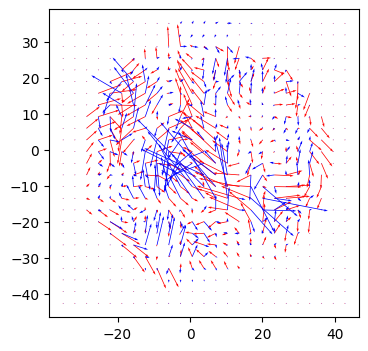

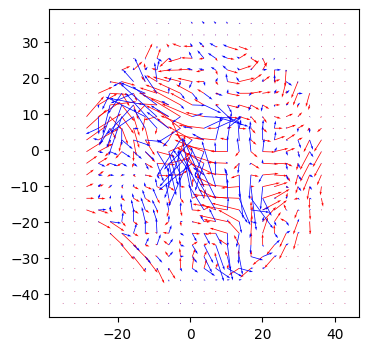

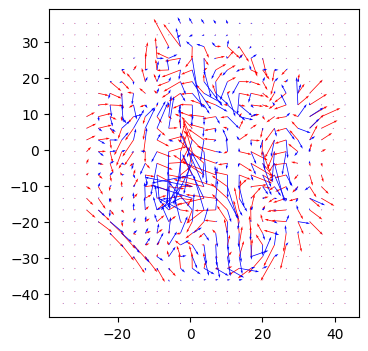

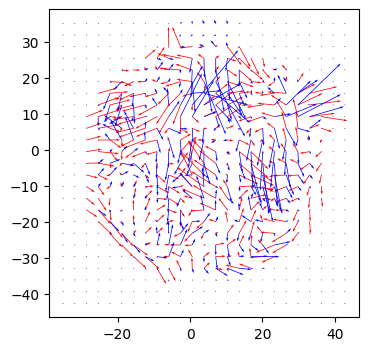

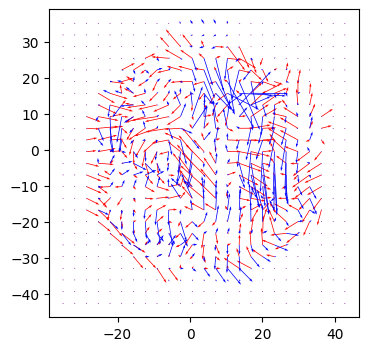

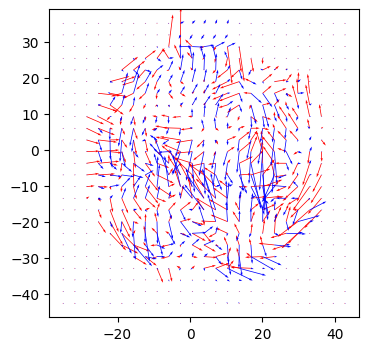

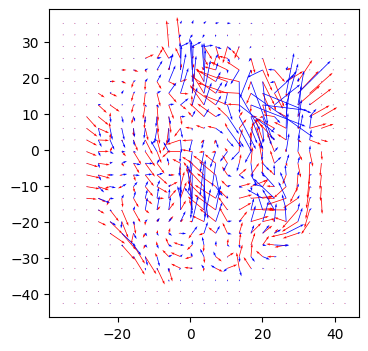

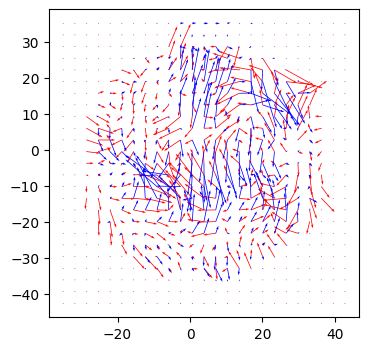

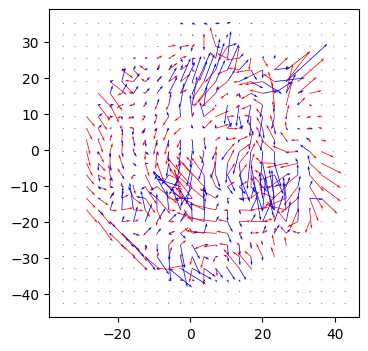

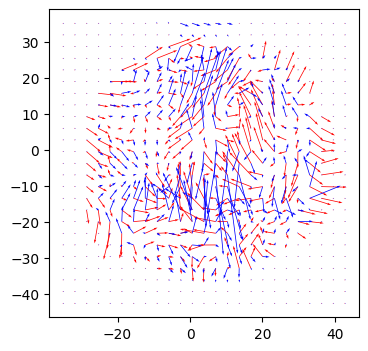

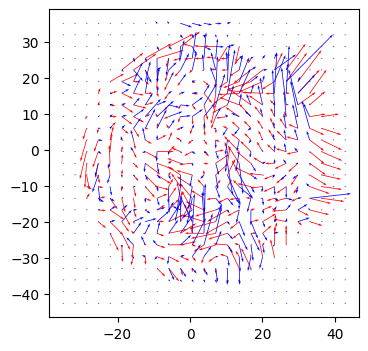

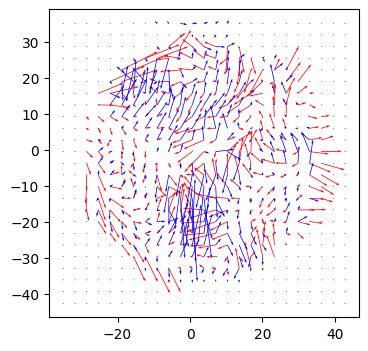

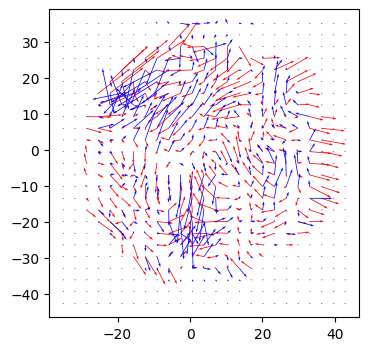

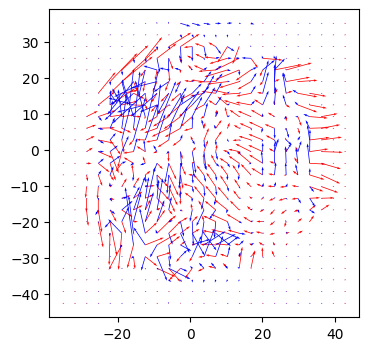

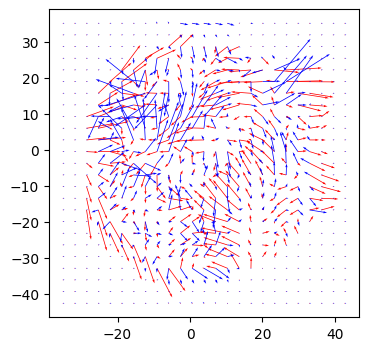

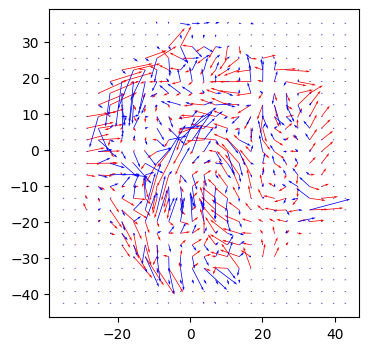

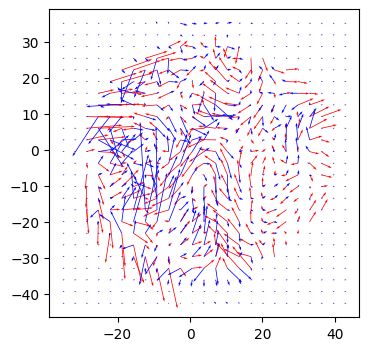

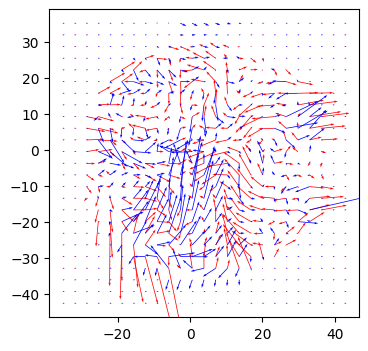

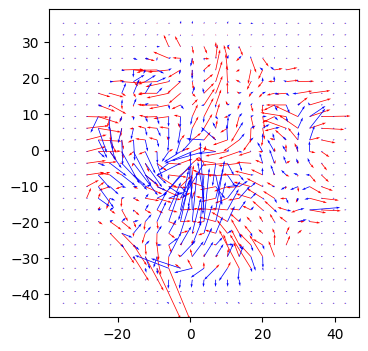

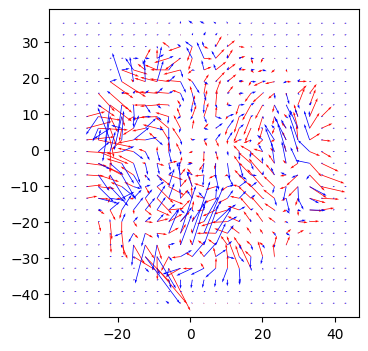

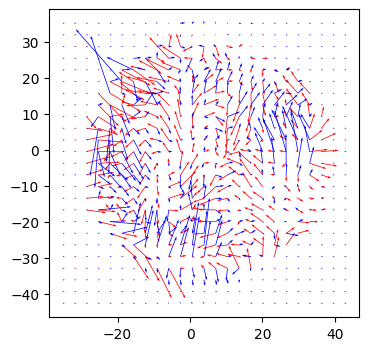

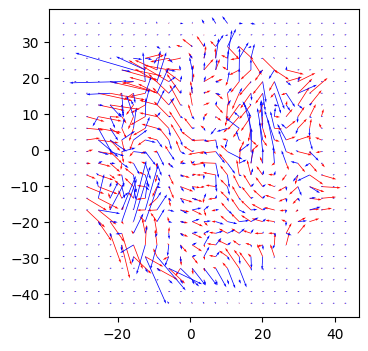

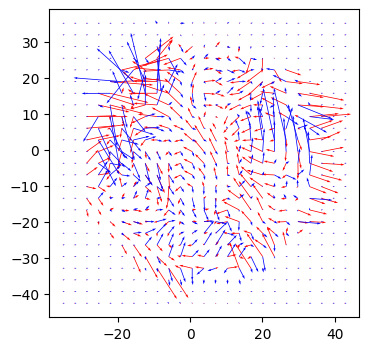

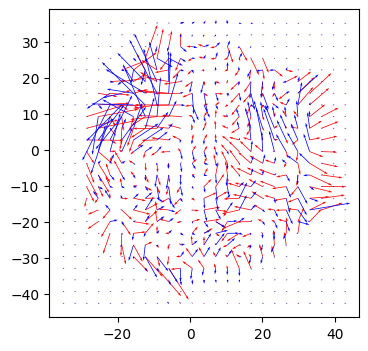

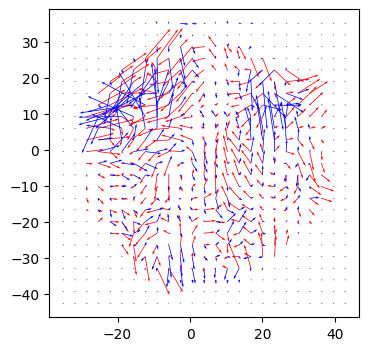

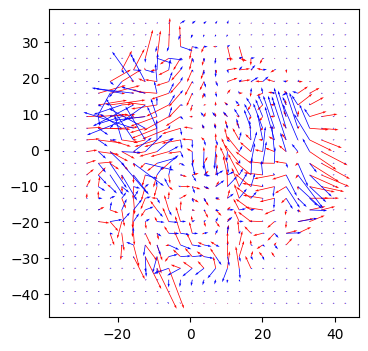

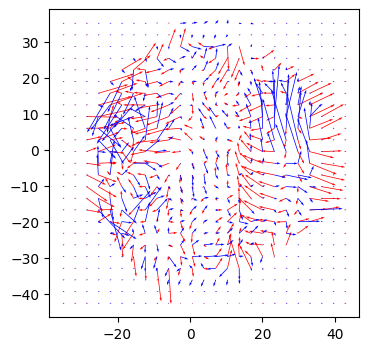

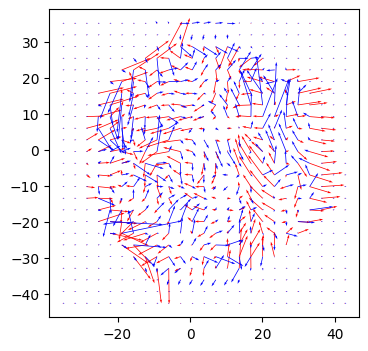

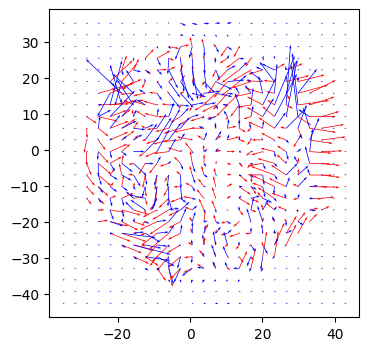

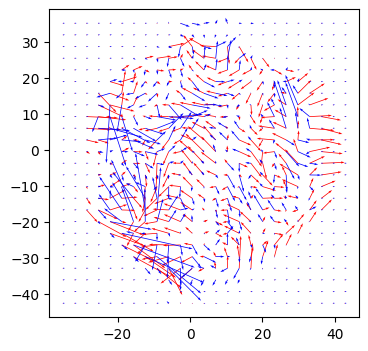

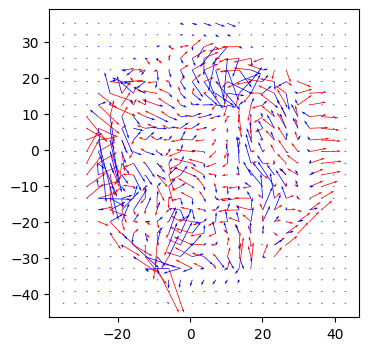

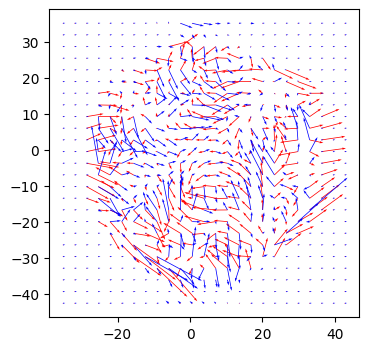

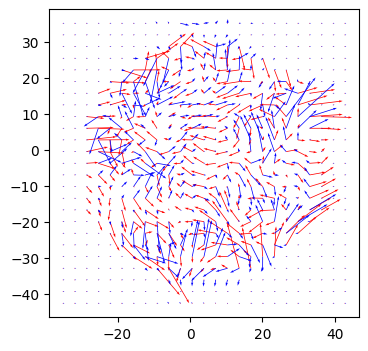

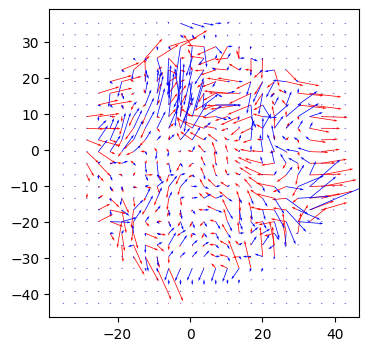

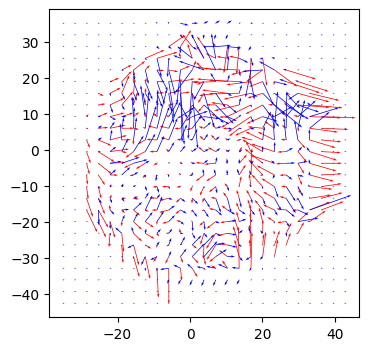

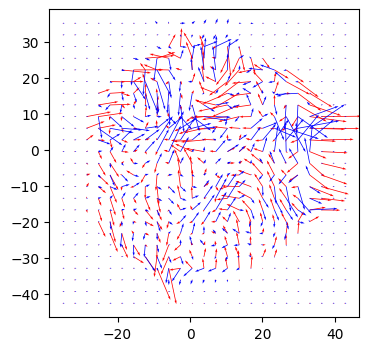

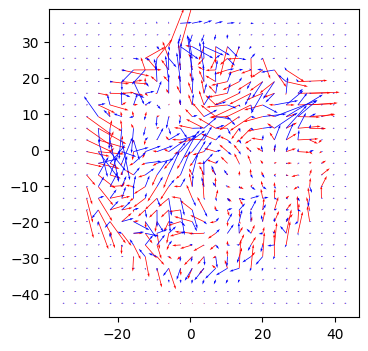

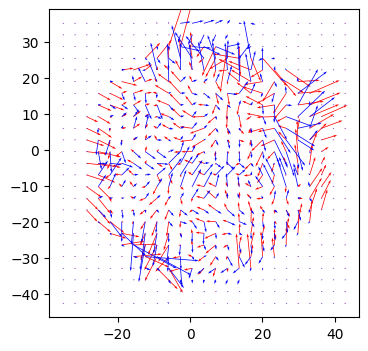

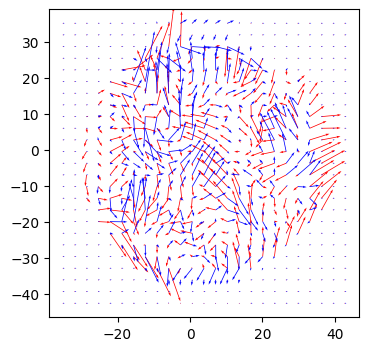

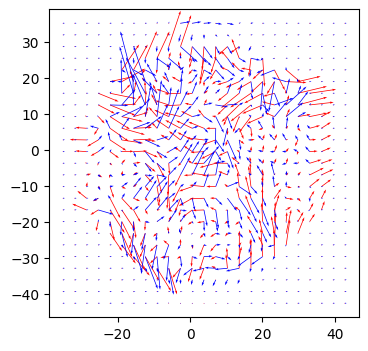

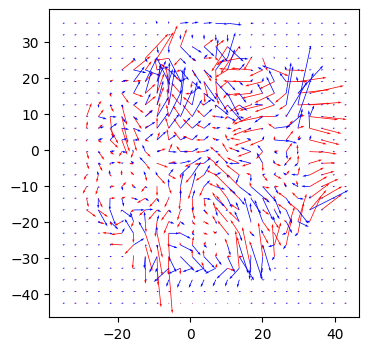

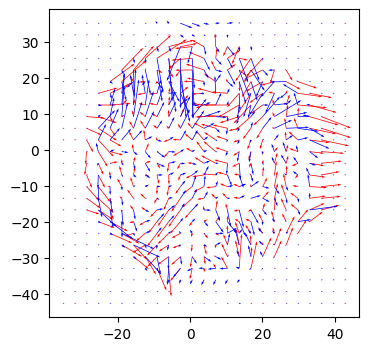

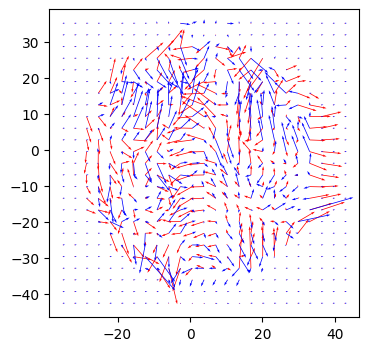

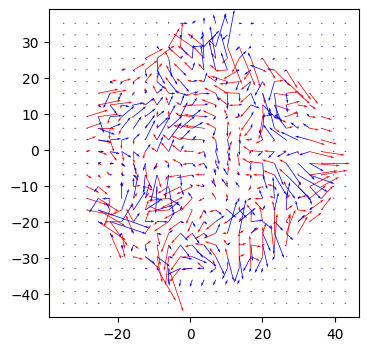

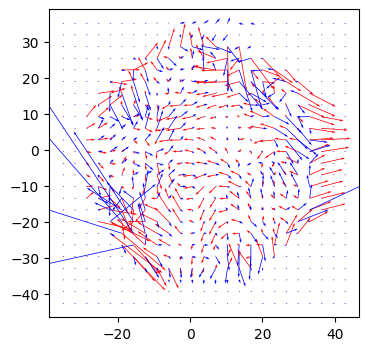

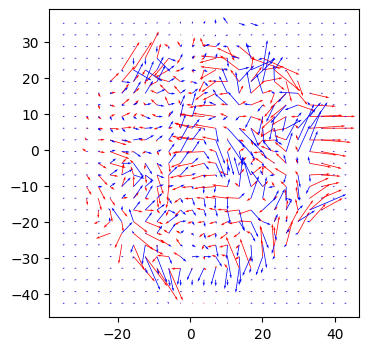

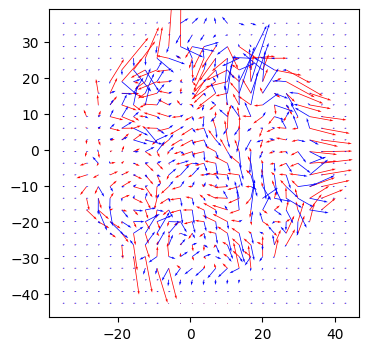

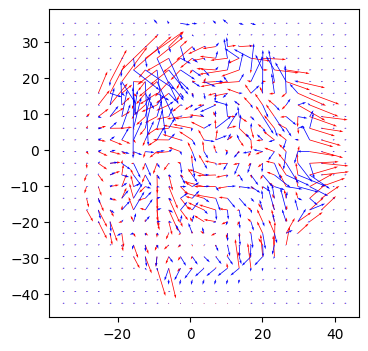

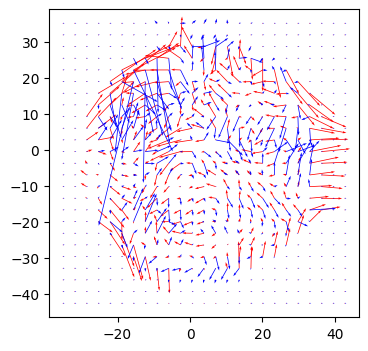

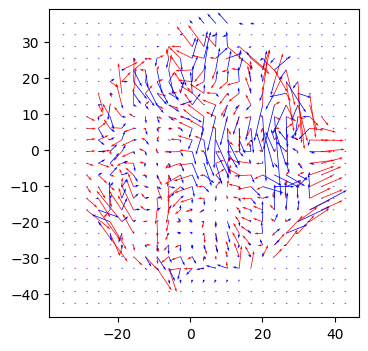

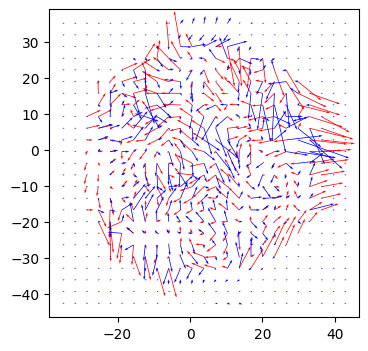

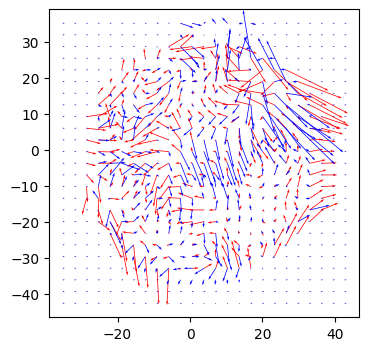

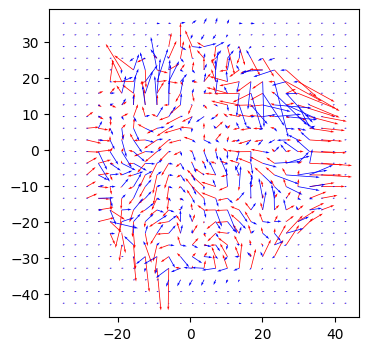

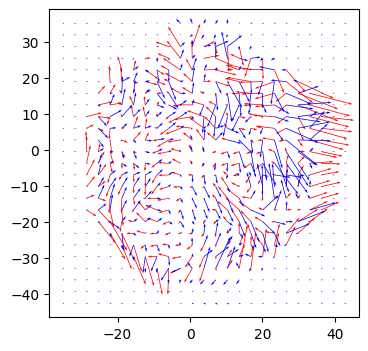

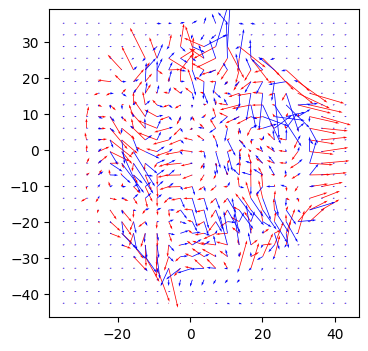

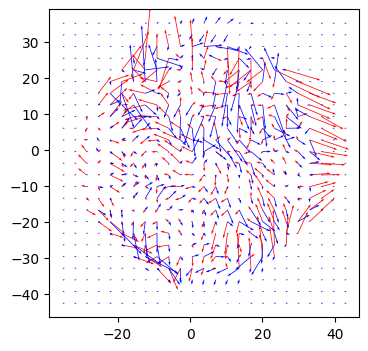

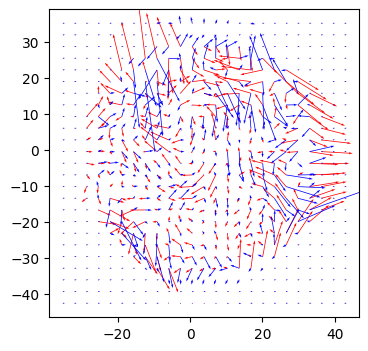

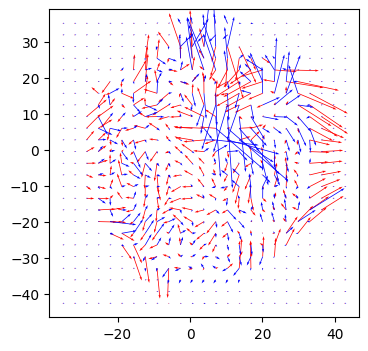

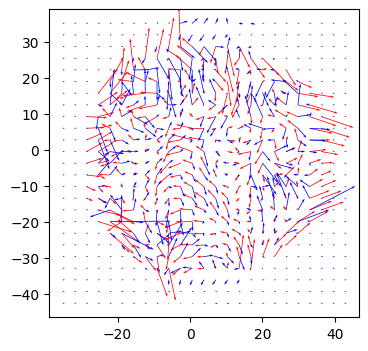

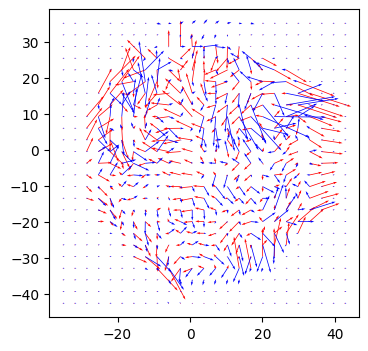

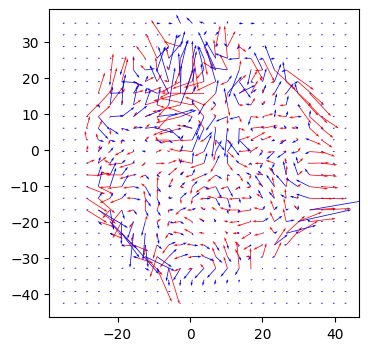

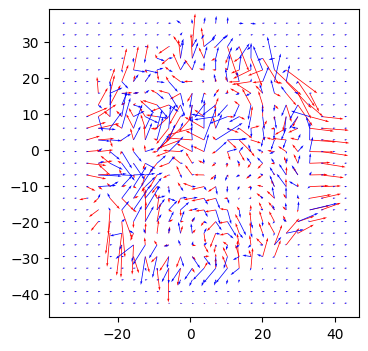

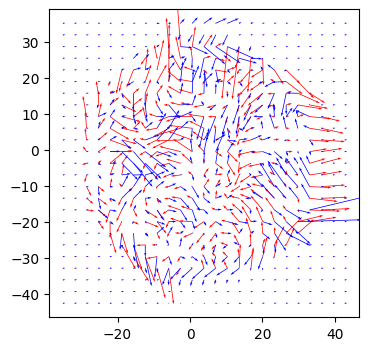

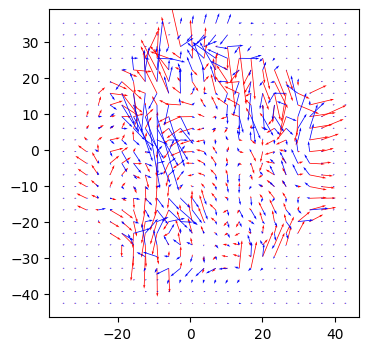

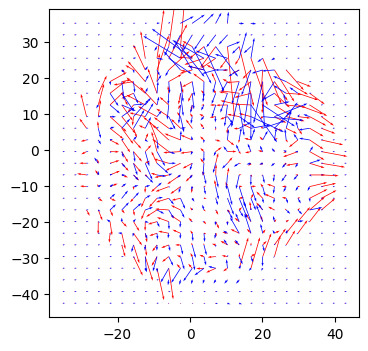

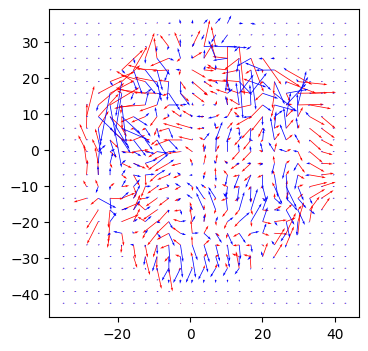

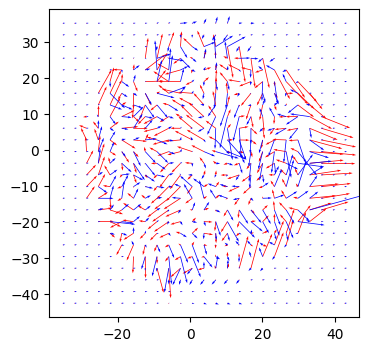

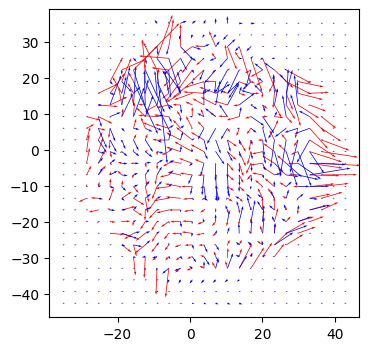

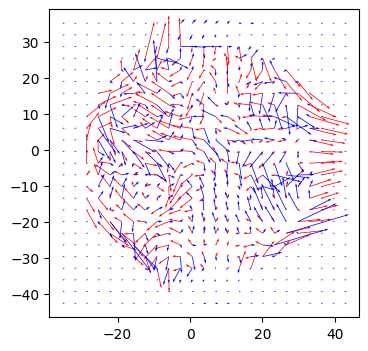

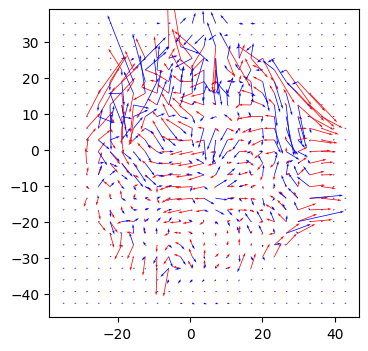

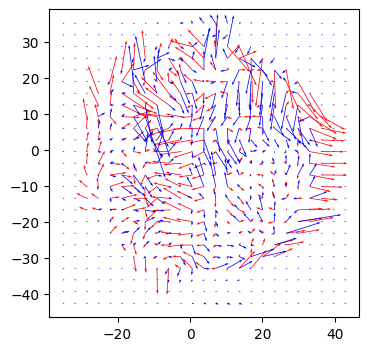

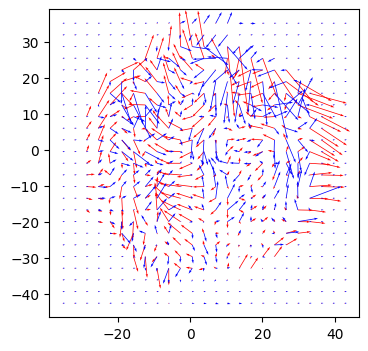

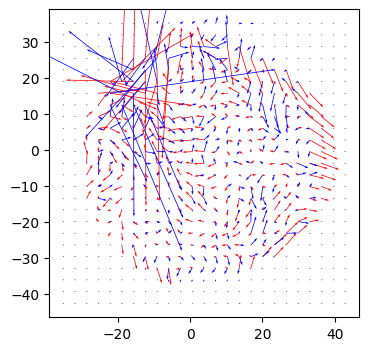

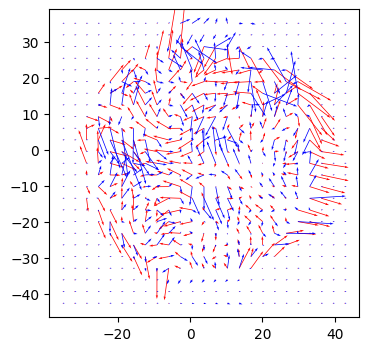

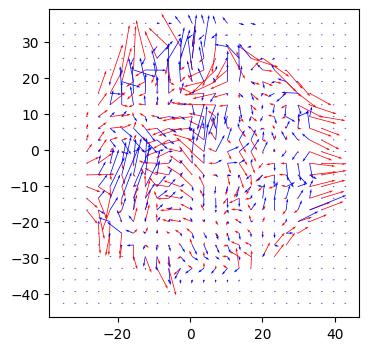

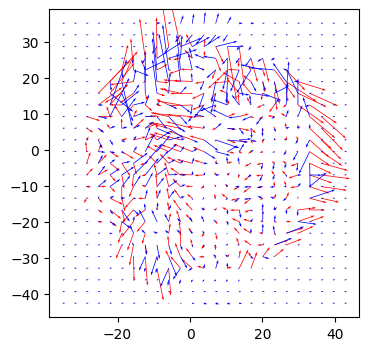

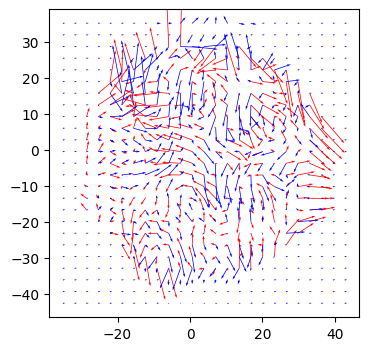

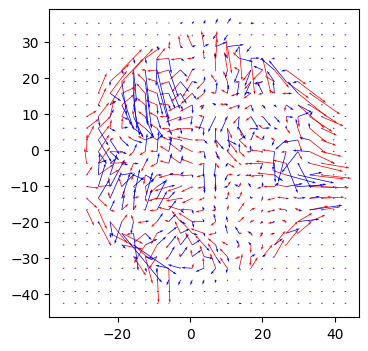

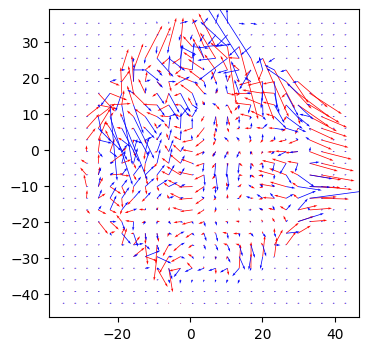

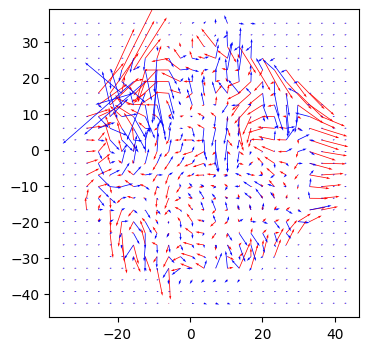

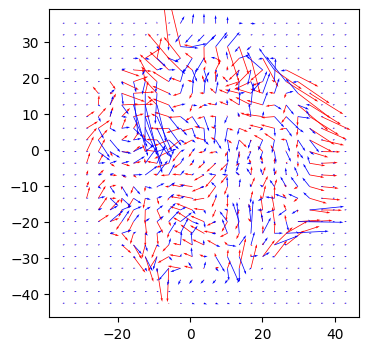

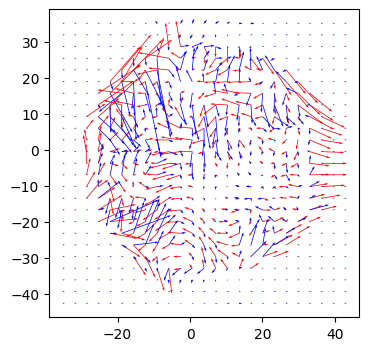

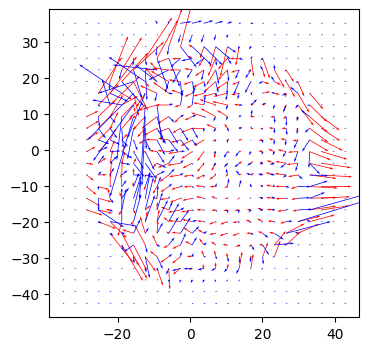

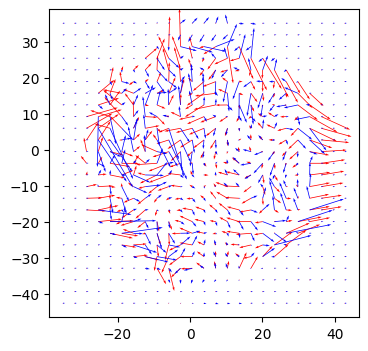

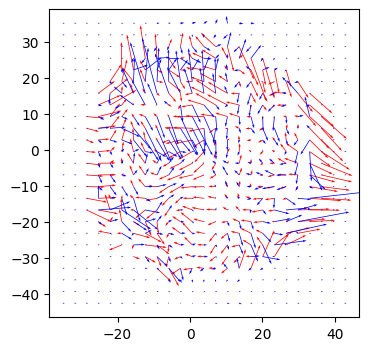

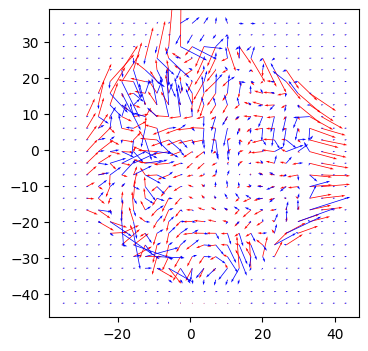

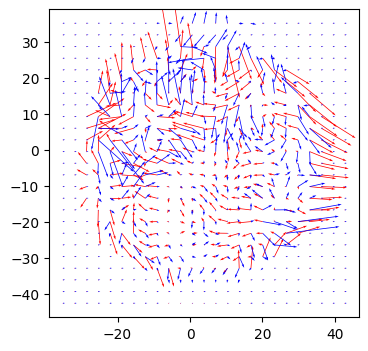

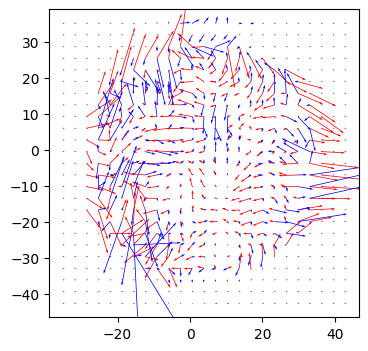

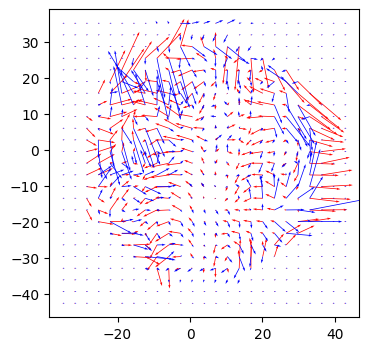

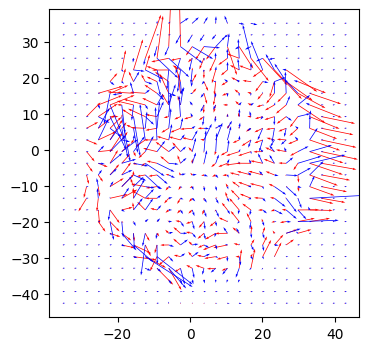

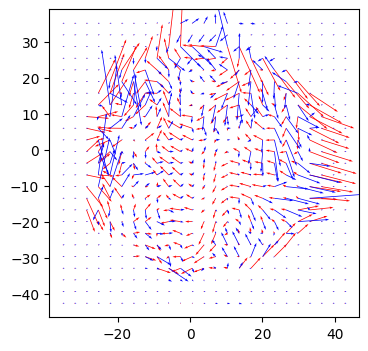

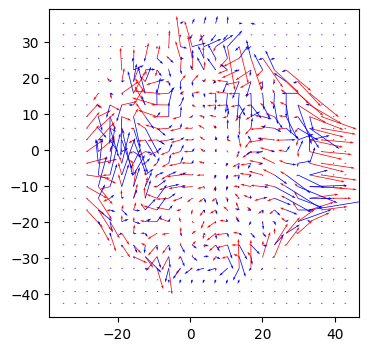

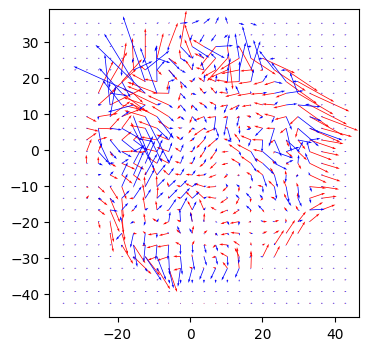

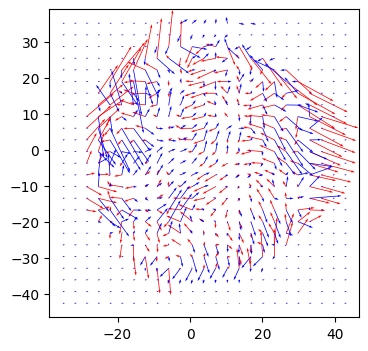

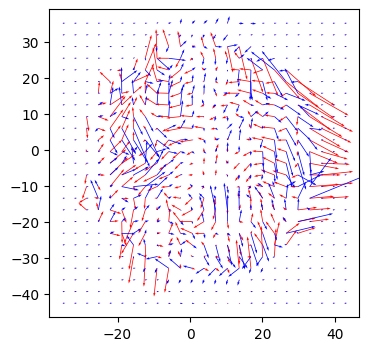

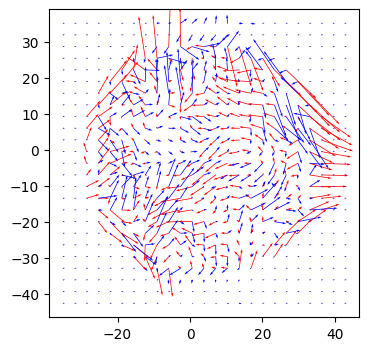

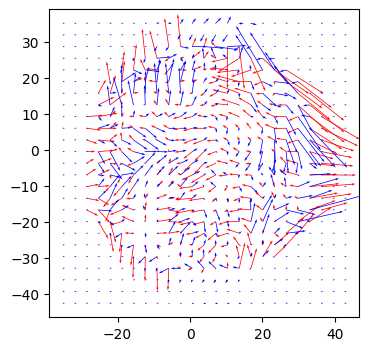

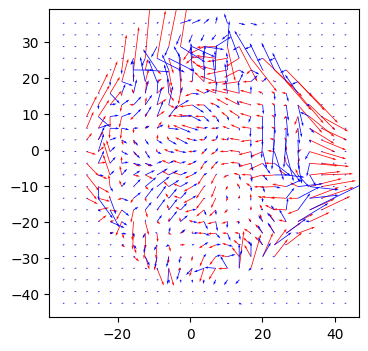

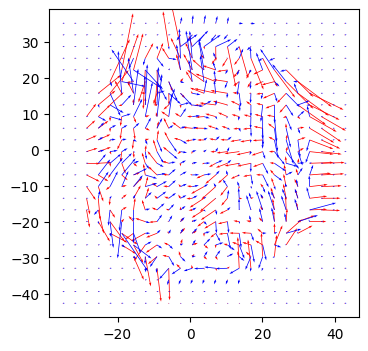

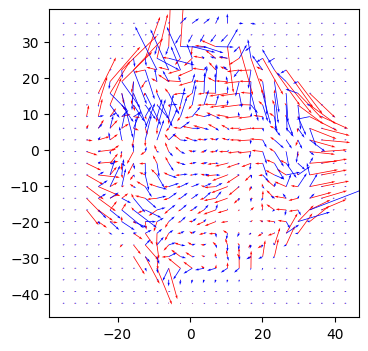

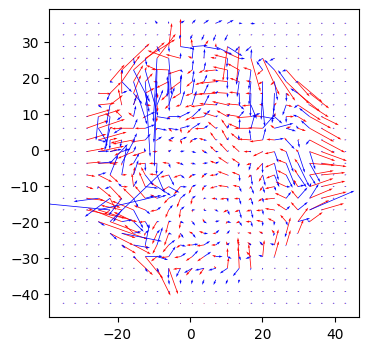

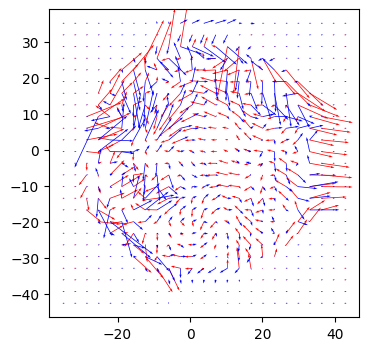

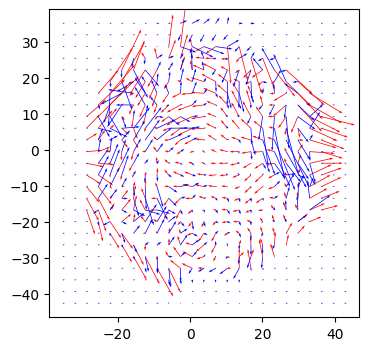

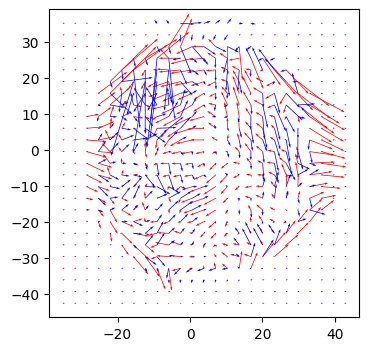

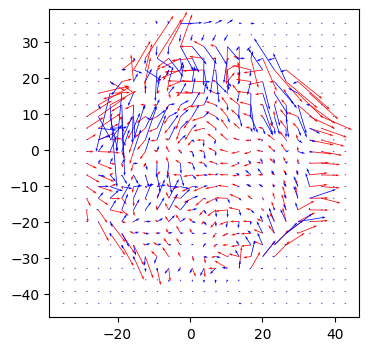

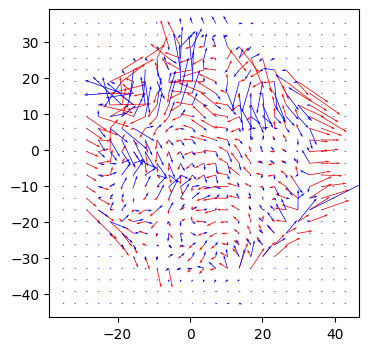

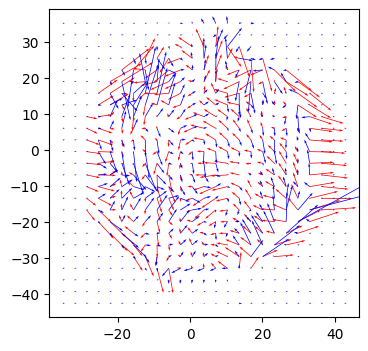

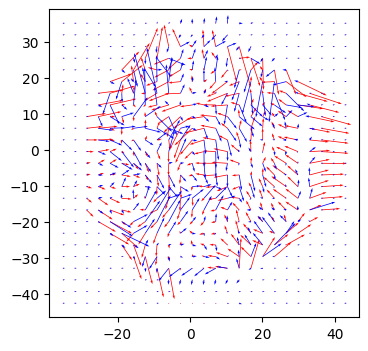

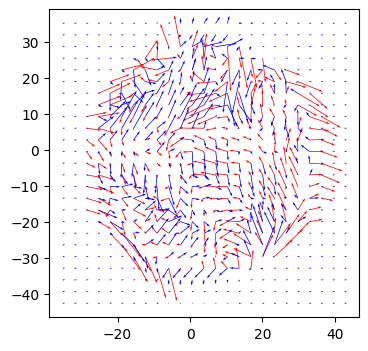

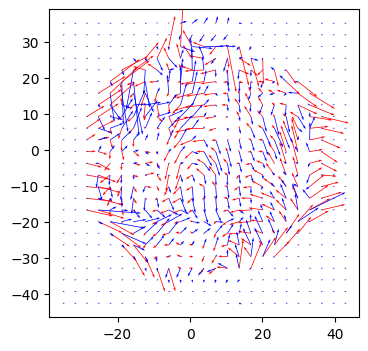

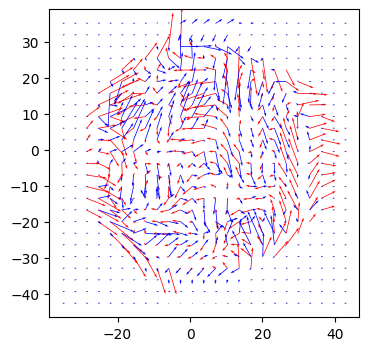

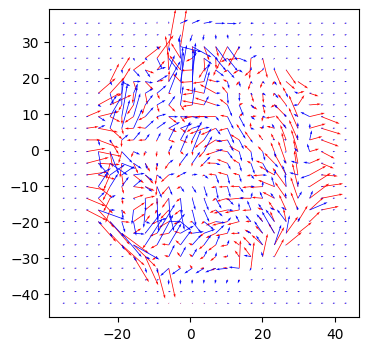

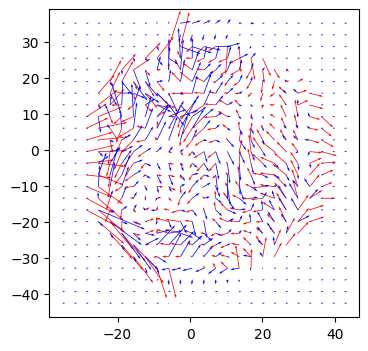

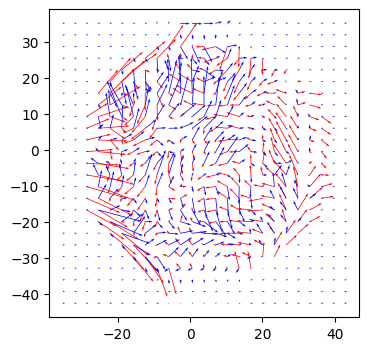

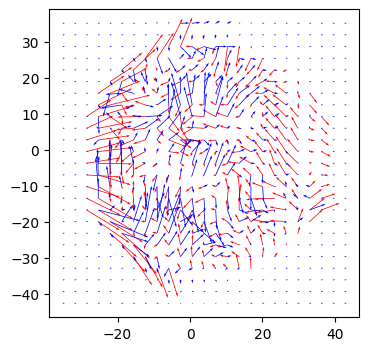

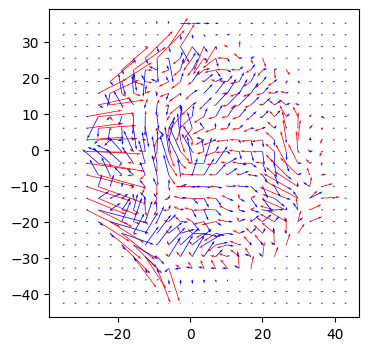

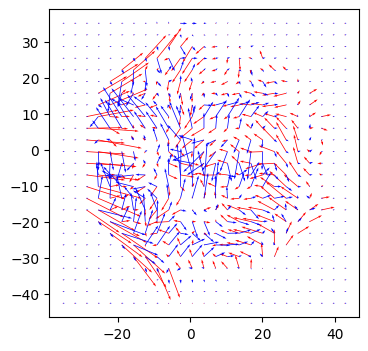

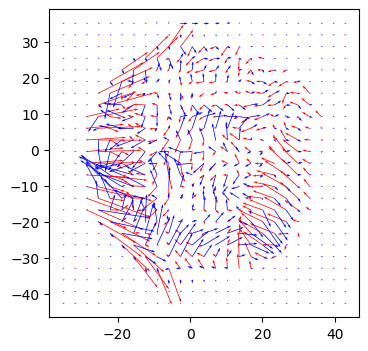

In [47]:

# Make fancy plot comparing derivative
plt.figure(figsize=(4, 4))
#plt.subplot(1, 3, 1)

print(x[0][0].shape)
'''
print(plttestvx[0].shape)
print(plttestvx[0])
'''
print(y.shape)
print(y[0,:,0])
ytmp=y[0,:,0]
ytmp=ytmp[::-1]
plt.figure(figsize=(4, 4))
plt.streamplot(x[0][0],ytmp,vx_dot[:,:,0],vy_dot[:,:,0])

plt.show()

print('x')
print(x[0].shape)
print('vx_dot[:,:,i]')
print(vx_dot[:,:,i].shape)
print('pltpredict[:,:,i,0]')
print(pltpredict[:,:,0,0].shape)
for i in range(1,120):
    
    plt.figure(figsize=(4, 4))
    plt.quiver(x[0],y[0],vx_dot[:,:,i],vy_dot[:,:,i],color='r')
    plt.quiver(x[0],y[0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
    plt.show()


